# Credit Card Defaults

## Data Preprocessing


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import utils

In [2]:
# Load the data
df = pd.read_csv('../data/UCI_Credit_Card.csv')
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [3]:
# Split the data into features and target
X = df.drop(columns=['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

In [4]:
# Check for missing values
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [5]:
# Check for duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis

In [6]:
# Describe the data
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


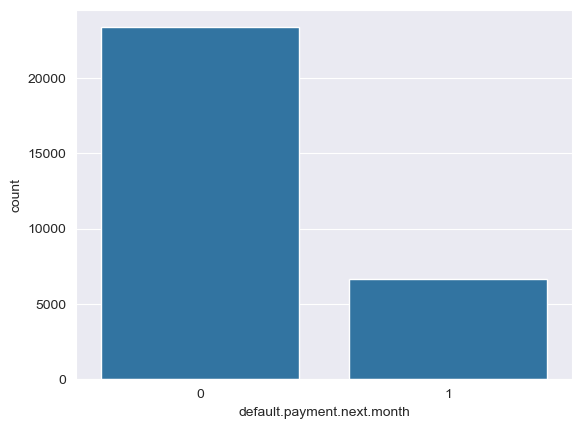

In [7]:
 # plot the distribution of the target variable
sns.countplot(x='default.payment.next.month', data=df)
plt.show()

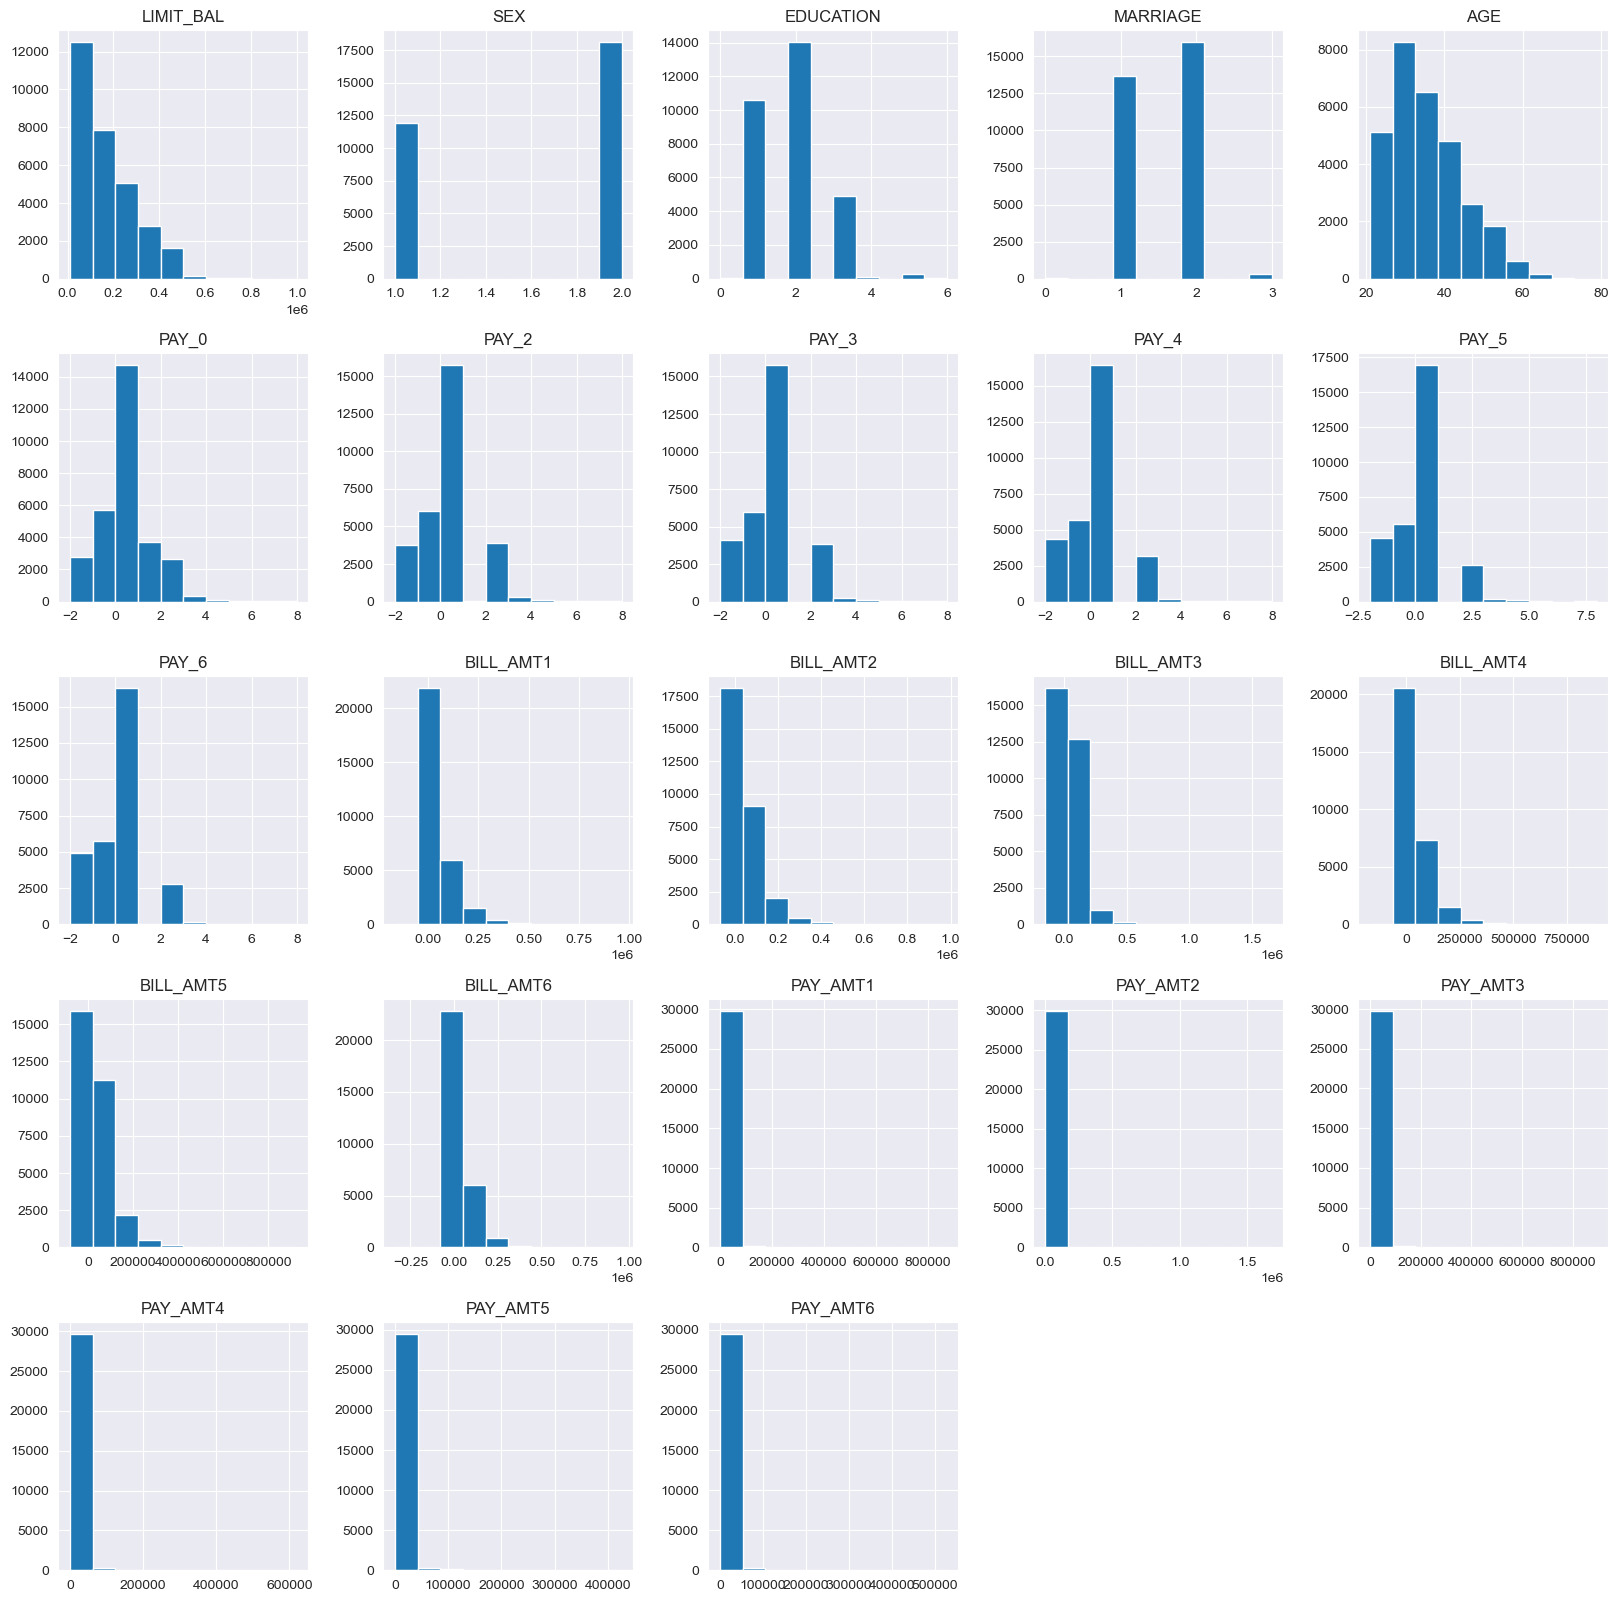

In [8]:
# plot the distribution of the features
X.hist(figsize=(20, 20))
plt.show()

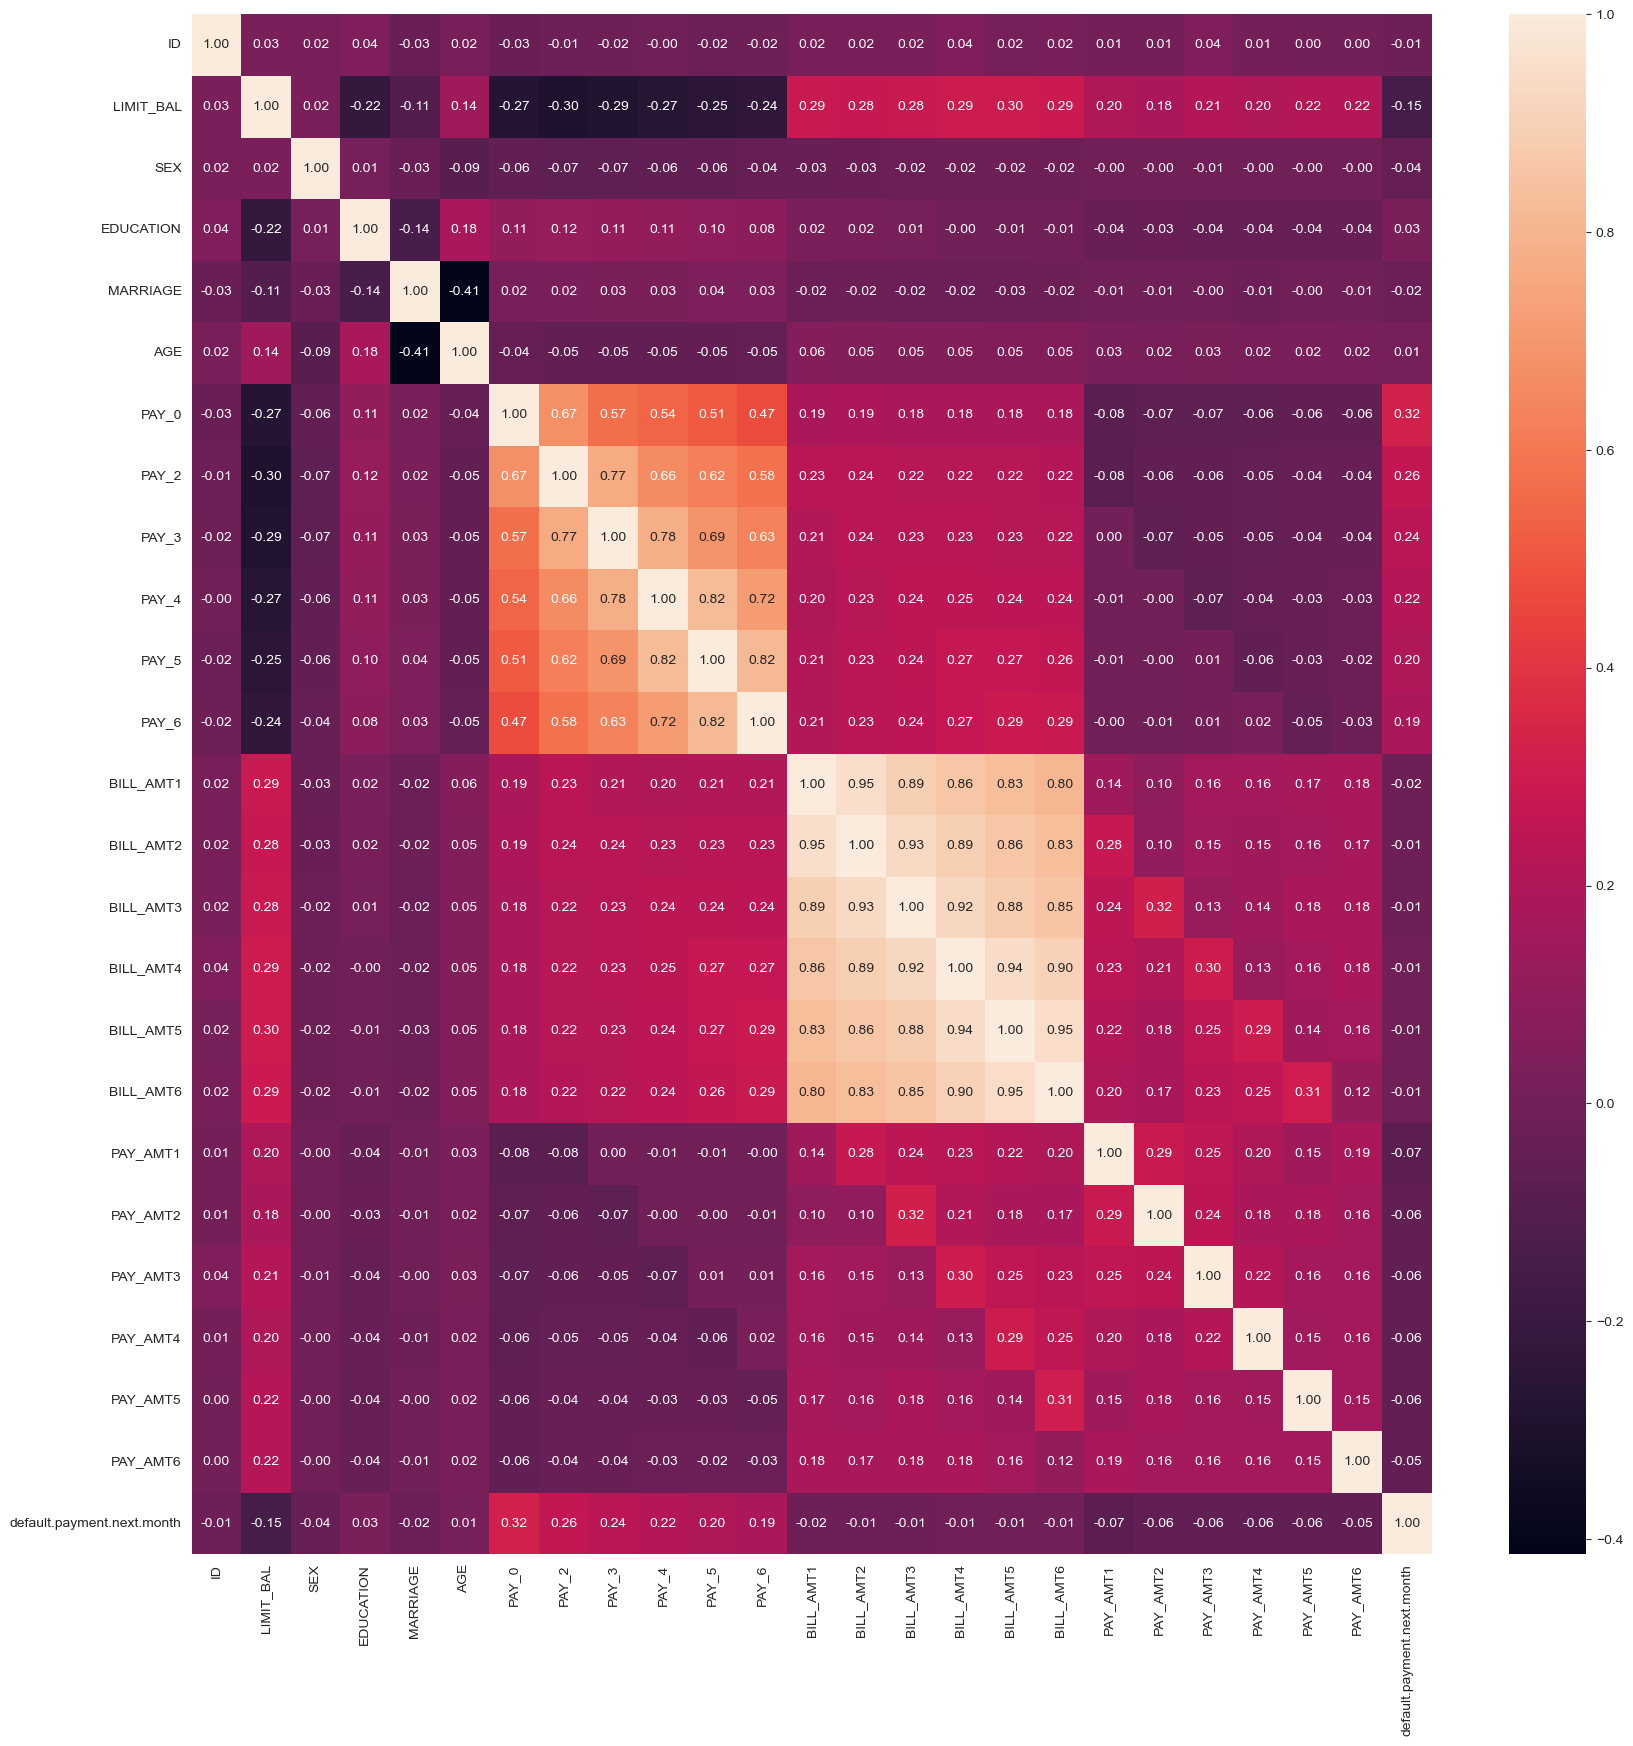

In [9]:
# plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

## Feature Engineering

### Remove Highly Correlated Features

In [10]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, threshold=5)
X_vif

Removed variables with high VIF:
BILL_AMT2: 38.21
BILL_AMT5: 35.98
BILL_AMT3: 24.12
BILL_AMT4: 15.18
AGE: 10.86
SEX: 8.08
BILL_AMT6: 5.12


,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,1,2,2,-1,-1,-2,-2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,-1,2,0,0,0,2,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,0,0,0,0,0,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,1,0,0,0,0,0,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,2,1,-1,0,-1,0,0,0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,3,1,0,0,0,0,0,0,188948.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,150000.0,3,2,-1,-1,-1,-1,0,0,1683.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,30000.0,2,2,4,3,2,-1,0,0,3565.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,80000.0,3,1,1,-1,0,0,0,-1,-1645.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


### Split the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

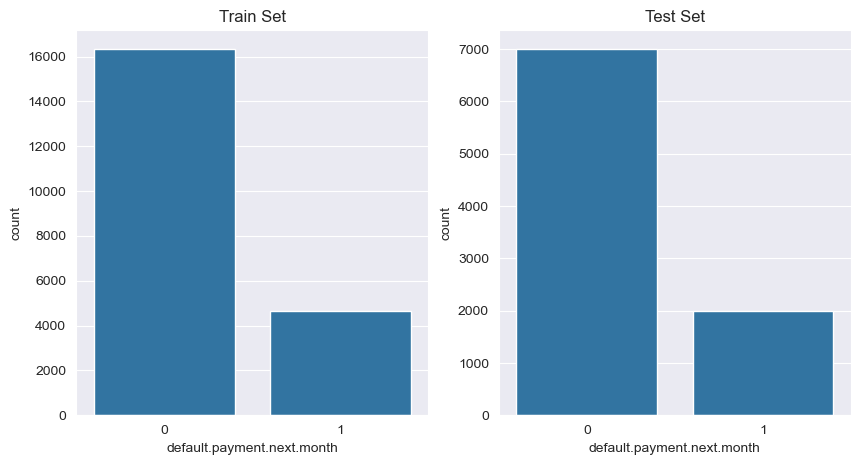

In [12]:
# plot the distribution of the target variable in the train and test sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Train Set')
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title('Test Set')
plt.show()

### Standardization (for Logistic Regression)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled array back to DataFrame with original column names
X_train_scaled_res_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

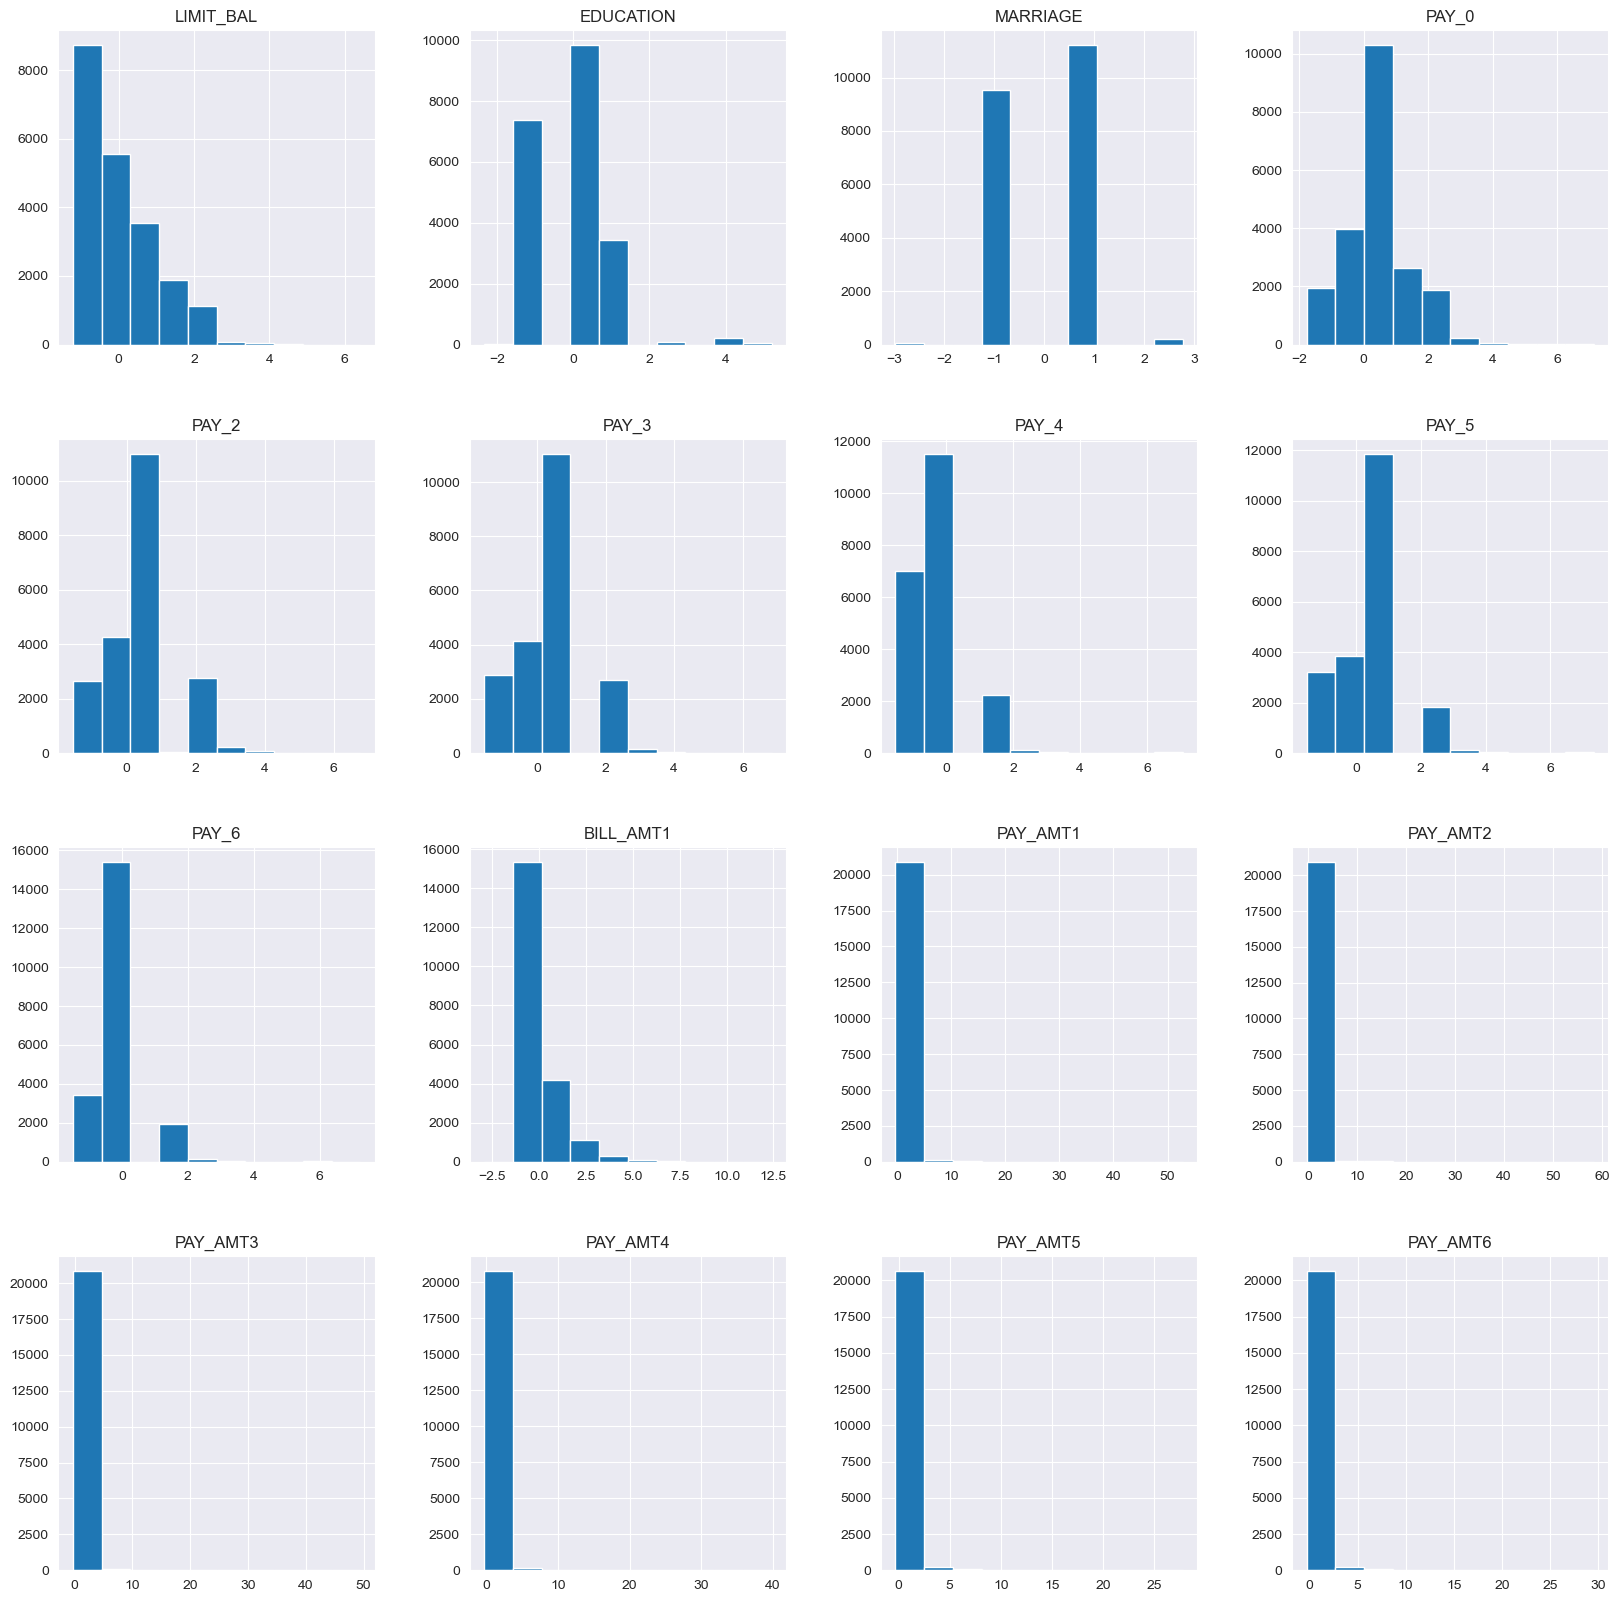

In [14]:
# Plot the distribution of the scaled features
pd.DataFrame(X_train_scaled_res_df).hist(figsize=(20, 20))
plt.show()

## Model Selection

### Scoring and Cross-Validation

In [15]:
# Define a custom scorer
scorer = make_scorer(f1_score)

We will use recall as the scoring metric because we want to minimize the number of false negatives. In the context of credit card defaults, a false negative would be predicting that a customer will not default when they actually do default. This would result in a financial loss for the credit card company.

In [16]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [17]:
# use logit regression as the model

# Reset the index of y_train to match X_train_scaled_const
y_train_scaled = y_train.reset_index(drop=True)

# Add a constant for the intercept
X_train_scaled_const = sm.add_constant(X_train_scaled_res_df)

logit_model = sm.Logit(y_train_scaled, X_train_scaled_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.463681
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                21000
Model:                                  Logit   Df Residuals:                    20983
Method:                                   MLE   Df Model:                           16
Date:                        Mon, 30 Sep 2024   Pseudo R-squ.:                  0.1225
Time:                                22:11:23   Log-Likelihood:                -9737.3
converged:                               True   LL-Null:                       -11097.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4646      0.020    -74.167 

In [18]:
# evaluate the model
X_test_scaled_const = sm.add_constant(X_test_scaled_df)
y_pred_prob = logit_model.predict(X_test_scaled_const)  # Predicted probabilities for test data
y_pred_logit = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

#### Hyperparameter Tuning

In [19]:
# create a sklearn model
lr_model = LogisticRegression(random_state=42)

In [20]:
# Define the parameter grid for GridSearchCV
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Optimization algorithms
    'max_iter': [100, 200, 500]  # Maximum number of iterations
}

##### GridSearchCV

In [21]:
# Create a GridSearchCV object
logit_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

logit_grid_search.fit(X_train_scaled_const, y_train_scaled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/py

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

##### Best Parameters and Score

In [22]:
# Print the best parameters and score
print("Best Parameters: ", logit_grid_search.best_params_)
print("Best Score: ", logit_grid_search.best_score_)

Best Parameters:  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.3662041578121248


In [23]:
# evaluate the model with the best hyperparameters
y_pred_lr_hyper = logit_grid_search.predict(X_test_scaled_const)

### Random Forest

In [24]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# evaluate the model
y_pred_rf = rf_model.predict(X_test)

#### Hyperparameter Tuning

In [26]:
# Define the parameter grid for GridSearchCV
param_distributions_rf = {
    'n_estimators': randint(100, 1000),  # Number of trees (100 to 1000)
    'max_depth': randint(1, 10),  # Depth of trees (1 to 10)
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

##### RandomizedSearchCV

In [27]:
# Create a GridSearchCV object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f8ad810>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f44e250>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f44e050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14fafcb50>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [28]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': False, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 752}
Best Score:  0.48329981999630006


In [29]:
# evaluate the model with the best hyperparameters
y_pred_rf_hyper = rf_random_search.predict(X_test)

### AdaBoost

In [30]:
# use adaboost as the model
base_estimator = DecisionTreeClassifier(random_state=42)

ada_model = AdaBoostClassifier(estimator=base_estimator, algorithm="SAMME", random_state=42)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(random_state=42),
                   random_state=42)

In [31]:
# evaluate the model
y_pred_ada = ada_model.predict(X_test)

#### Hyperparameter Tuning

In [32]:
# Define the parameter grid for GridSearchCV
param_distributions_ada = {
    'n_estimators': randint(50, 500),  # Number of boosting stages
    'learning_rate': uniform(0.01, 1),  # Shrinkage step size
    'estimator__max_depth': randint(1, 10),  # Tuning max depth of base decision tree
    'estimator__min_samples_split': randint(2, 20),  # Min samples to split in the base tree
    'estimator__min_samples_leaf': randint(1, 10),  # Min samples for leaves
}

##### RandomizedSearchCV

In [33]:
# Create a GridSearchCV object
ada_grid_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_distributions_ada,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

ada_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(random_state=42),
                                                random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f1507d0>,
                                        'estimator__min_sa...
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f15d9d0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f110350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f112350>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [34]:
# Print the best parameters and score
print("Best Parameters: ", ada_grid_search.best_params_)
print("Best Score: ", ada_grid_search.best_score_)

Best Parameters:  {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2, 'learning_rate': 0.6159599747810114, 'n_estimators': 280}
Best Score:  0.4842748928084332


In [35]:
# evaluate the model with the best hyperparameters
y_pred_ada_hyper = ada_grid_search.predict(X_test)

### XGBoost

In [36]:
# use xgboost as the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

#### Hyperparameter Tuning

In [38]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'max_depth': randint(3, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

##### RandomizedSearchCV

In [79]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train, y_train, verbose=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f641510>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f4c3fd0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f4c3d10>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [80]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.24874024515670226, 'gamma': 0.007818203370596966, 'learning_rate': 0.1370204442119109, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 571, 'scale_pos_weight': 3, 'subsample': 0.7361716094628554}
Best Score:  0.5389444696480872


In [81]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper = xgb_random_search.predict(X_test)

## Model Evaluation

### Logistic Regression

#### Coefficients

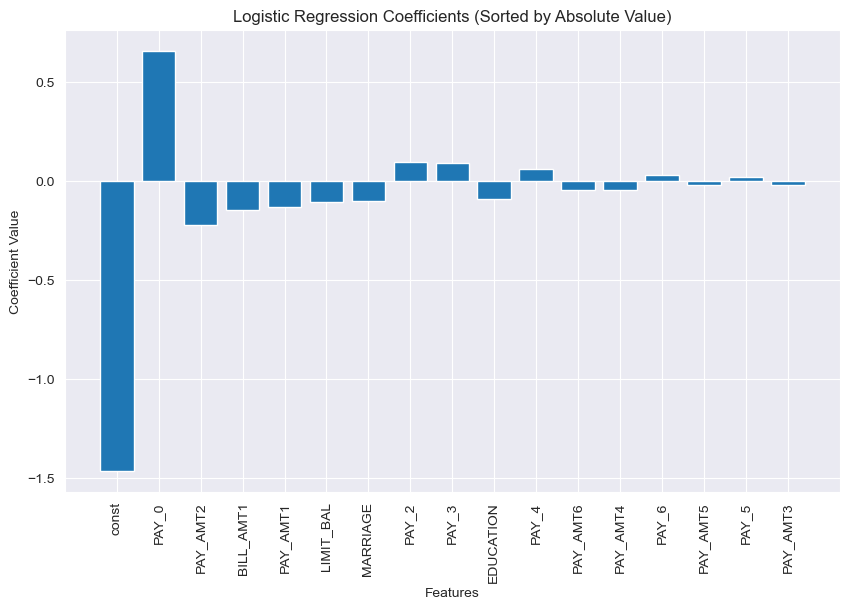

In [42]:
# Extract the coefficients
coefficients = logit_model.params

# Sort the coefficients by their absolute values
sorted_coefficients = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

# Extract the feature names
sorted_features = sorted_coefficients.index.tolist()

# Plot the sorted feature names
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_coefficients)
plt.title('Logistic Regression Coefficients (Sorted by Absolute Value)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [43]:
accuracy = accuracy_score(y_test, y_pred_logit)
print("Accuracy:", accuracy)

Accuracy: 0.8082222222222222


#### Confusion Matrix

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred_logit)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6801  208]
 [1518  473]]


#### Classification Report

In [45]:
# use classification report
class_report = classification_report(y_test, y_pred_logit)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.69      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



This model is doing a good job predicting when people are not going to default on their credit cards, but it is doing a poor job of predicting when people are going to default on their credit cards. The model has a high precision and recall for the negative class, but a low precision and recall for the positive class.

#### ROC Curve

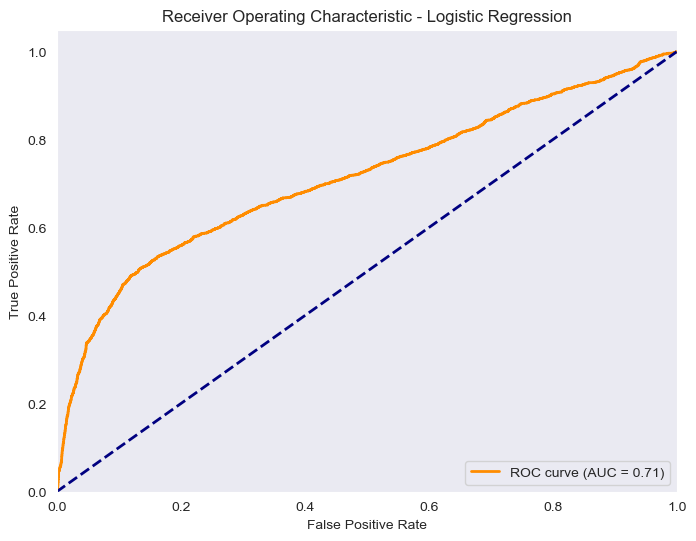

In [46]:
# plot roc curve
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Logistic Regression')

#### with Hyperparameter Tuning

##### Accuracy

In [47]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.8082222222222222


##### Confusion Matrix

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred_lr_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6801  208]
 [1518  473]]


##### Classification Report

In [49]:
# use classification report
class_report = classification_report(y_test, y_pred_lr_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.69      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



##### ROC Curve

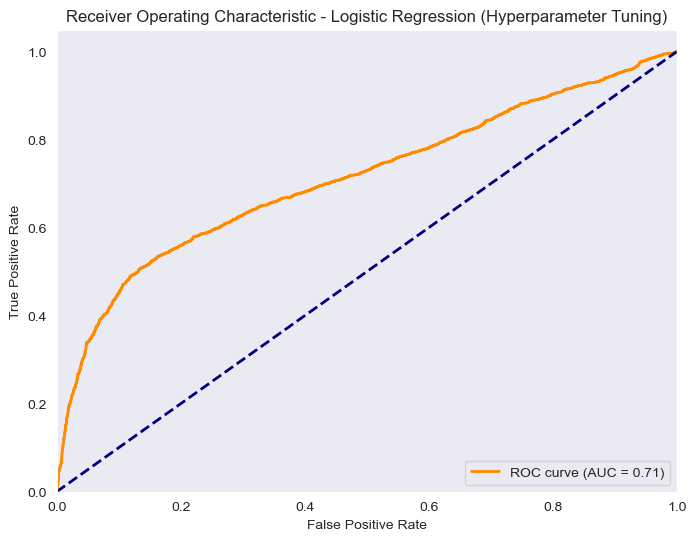

In [50]:
# plot roc curve
y_pred_prob = logit_grid_search.predict_proba(X_test_scaled_const)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Logistic Regression (Hyperparameter Tuning)')

### Random Forest

#### Feature Importances

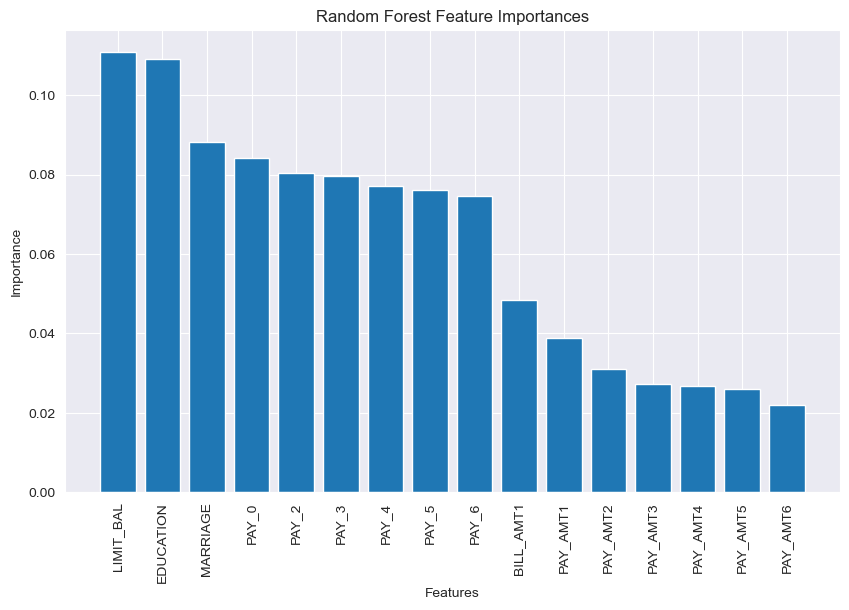

In [51]:
# plot the feature importances

# Extract the feature importances
feature_importances = rf_model.feature_importances_

# Sort the feature importances
sorted_indices = feature_importances.argsort()[::-1]
feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [52]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.814


#### Confusion Matrix

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6586  423]
 [1251  740]]


#### Classification Report

In [54]:
# use classification report
class_report = classification_report(y_test, y_pred_rf)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.37      0.47      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.81      0.79      9000



#### ROC Curve

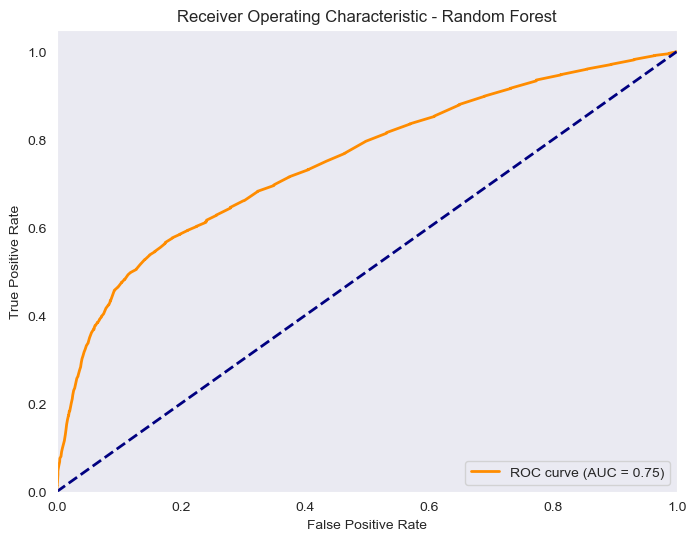

In [55]:
# plot roc curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Random Forest')

#### with Hyperparameter Tuning

##### Accuracy

In [56]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.8177777777777778


##### Confusion Matrix

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6646  363]
 [1277  714]]


##### Classification Report

In [58]:
# use classification report
class_report = classification_report(y_test, y_pred_rf_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000



##### ROC Curve

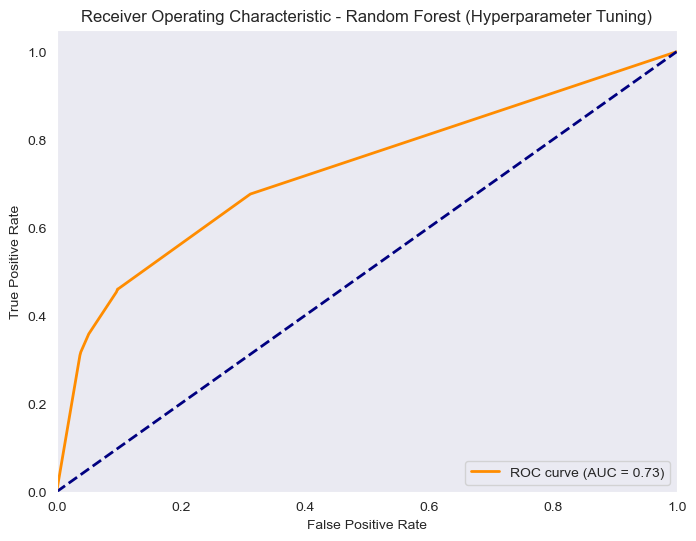

In [59]:
# plot roc curve
y_pred_prob = rf_random_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Random Forest (Hyperparameter Tuning)')

### AdaBoost

#### Feature Importances

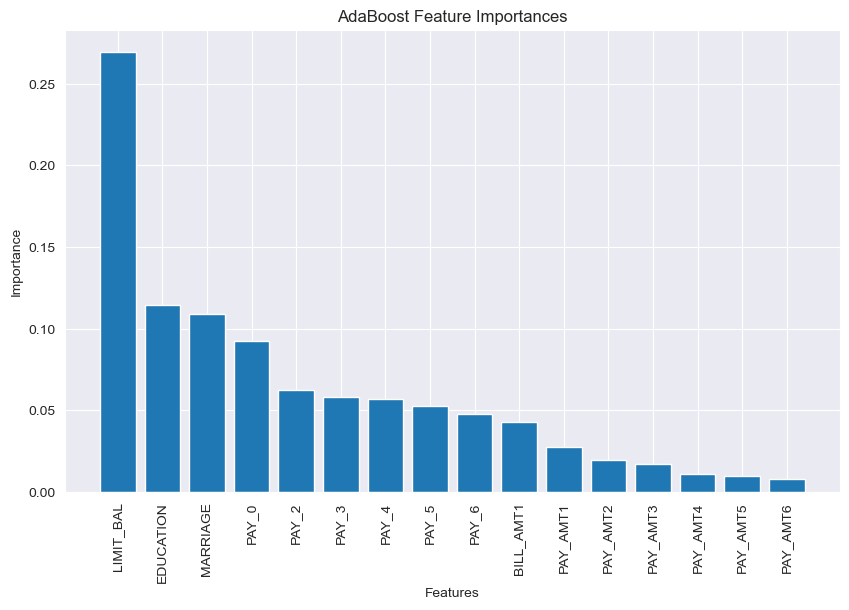

In [60]:
# plot the feature importances
feature_importances = ada_model.feature_importances_

# Sort the feature importances
sorted_indices = feature_importances.argsort()[::-1]
feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.title('AdaBoost Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [61]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_ada)
print("Accuracy:", accuracy)

Accuracy: 0.7417777777777778


#### Confusion Matrix

In [62]:
conf_matrix = confusion_matrix(y_test, y_pred_ada)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[5855 1154]
 [1170  821]]


#### Classification Report

In [63]:
# use classification report
class_report = classification_report(y_test, y_pred_ada)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      7009
           1       0.42      0.41      0.41      1991

    accuracy                           0.74      9000
   macro avg       0.62      0.62      0.62      9000
weighted avg       0.74      0.74      0.74      9000



#### ROC Curve

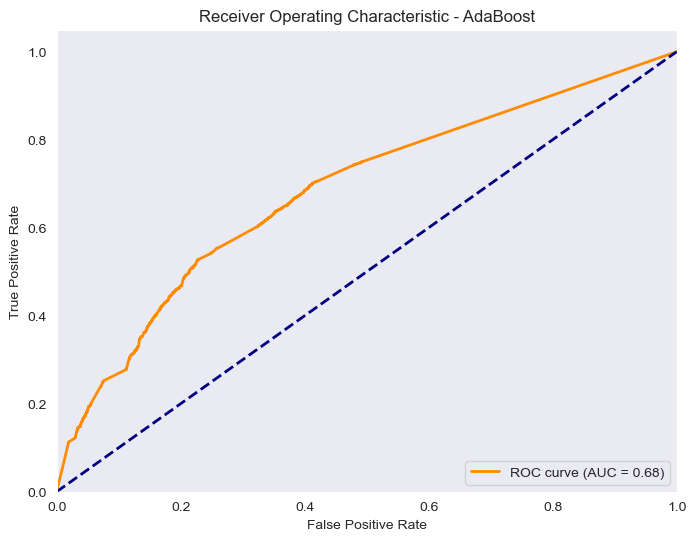

In [64]:
# plot roc curve
y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='AdaBoost')

#### with Hyperparameter Tuning

##### Accuracy

In [65]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_ada_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.8181111111111111


##### Confusion Matrix

In [66]:
conf_matrix = confusion_matrix(y_test, y_pred_ada_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6644  365]
 [1272  719]]


##### Classification Report

In [67]:
# use classification report
class_report = classification_report(y_test, y_pred_ada_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000



##### ROC Curve

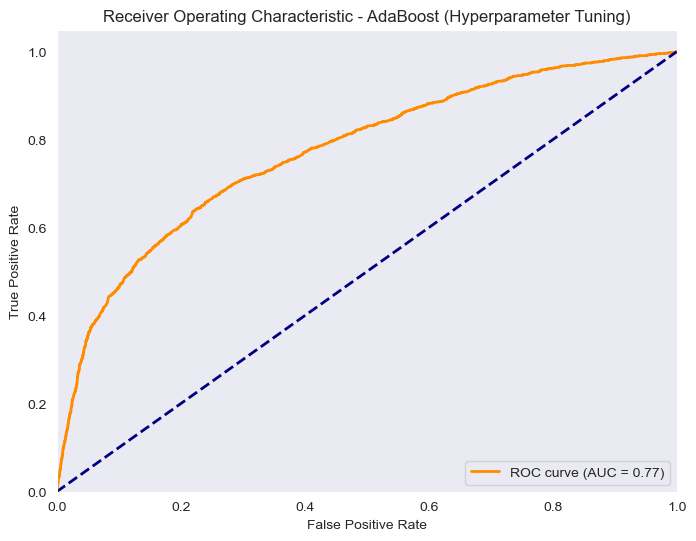

In [68]:
# plot roc curve
y_pred_prob = ada_grid_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='AdaBoost (Hyperparameter Tuning)')

### XGBoost

#### Feature Importances

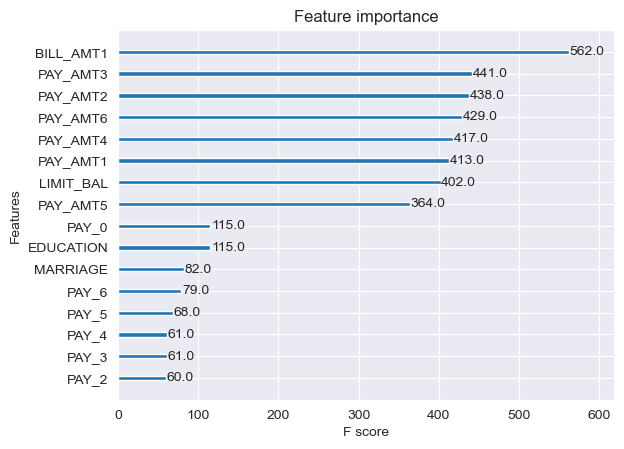

In [69]:
# plot the feature importances
xgb.plot_importance(xgb_model)
plt.show()

#### Accuracy

In [70]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.8087777777777778


#### Confusion Matrix

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[6573  436]
 [1285  706]]


#### Classification Report

In [72]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      7009
           1       0.62      0.35      0.45      1991

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



#### ROC Curve

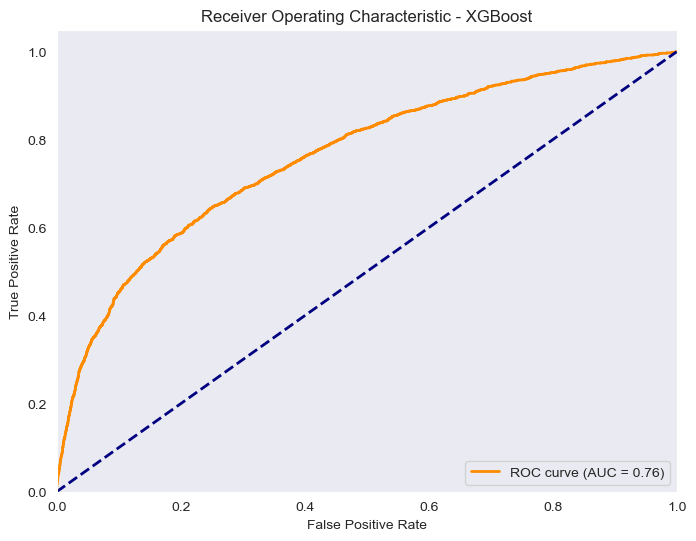

In [73]:
# plot roc curve
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='XGBoost')

#### with Hyperparameter Tuning

##### Accuracy

In [82]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.7734444444444445


##### Confusion Matrix

In [83]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[5787 1222]
 [ 817 1174]]


##### Classification Report

In [84]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      7009
           1       0.49      0.59      0.54      1991

    accuracy                           0.77      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.77      0.78      9000



##### ROC Curve

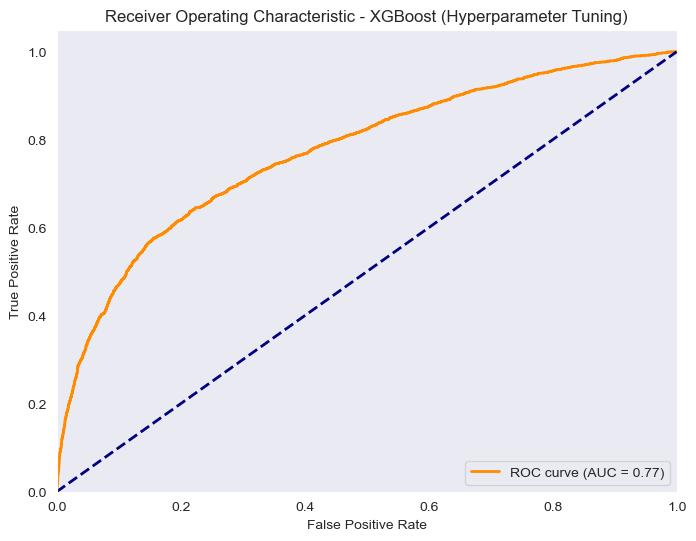

In [85]:
# plot roc curve
y_pred_prob = xgb_random_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='XGBoost (Hyperparameter Tuning)')

### Combined Model Scores

In [86]:
# Create a DataFrame with the model statistics with and without hyperparameter tuning
models = ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost']
predictions_base = [y_pred_logit, y_pred_rf, y_pred_ada, y_pred_xgb]
predictions_hyper = [y_pred_lr_hyper, y_pred_rf_hyper, y_pred_ada_hyper, y_pred_xgb_hyper]

results = utils.evaluate_models(models=models, predictions_base=predictions_base, predictions_hyper=predictions_hyper,
                                y_test=y_test)
results

,,Logistic Regression,Random Forest,AdaBoost,XGBoost,Best Model,Highest Value
Metric,Type,,,,,,
Accuracy,Base,0.808222,0.814,0.741778,0.808778,AdaBoost,0.818111
Precision,Base,0.694567,0.636285,0.415696,0.618214,Logistic Regression,0.694567
Recall,Base,0.237569,0.371673,0.412356,0.354596,XGBoost,0.589653
F1 Score,Base,0.354042,0.469245,0.414019,0.450686,XGBoost,0.535218
Positive Precision,Base,0.694567,0.636285,0.415696,0.618214,Logistic Regression,0.694567
Negative Precision,Base,0.817526,0.840373,0.833452,0.836472,XGBoost,0.876287
Positive Recall,Base,0.237569,0.371673,0.412356,0.354596,XGBoost,0.589653
Negative Recall,Base,0.970324,0.939649,0.835355,0.937794,Logistic Regression,0.970324
Positive F1 Score,Base,0.354042,0.469245,0.414019,0.450686,XGBoost,0.535218
